## Generate stagnated water field for DG

### Ingredients:

1. Neches River CG output in netCDF format (CG and DG are sharing the same mesh)
2. Neches River DG output (in plain text)
3. [Kalpana](https://github.com/ccht-ncsu/Kalpana.git) downloaded to local. Create your own directory under /Kalpana/examples or other subdirectory (make sure you can import kalpana functions)

All the input files have been uploaded to [Google Drive](https://drive.google.com/drive/folders/1sACCBtnTYn7o33siWg8-y_zDnZqARSBs?usp=share_link) (shared with Katy) and saved to the group's HardDrive.

In [8]:
import netCDF4 as nc
import numpy as np
import stagnated
import sys

#import Kalpana functions from github repository
# change these to your own paths!
sys.path.append('/Users/liting/Documents/GitHub/Kalpana')
from kalpana.export import *
from kalpana.visualizations import *
import contextily as cx
import os
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.features import rasterize
from netCDF4 import Dataset
#from modified_functions import *


time_dim = 354  # number of DG time steps
stag_output_dir = '/Users/liting/Desktop/stag-water2'

### 1) Save fort.63 to  fort.63.dg.nc

In [ ]:
import netCDF4 as nc
import numpy as np

# === File paths and settings ===
cg_nc_path = "/Users/liting/Documents/GitHub/Kalpana/examples/test/fort.63.nc"
dg_path = "/Users/liting/Documents/GitHub/Kalpana/examples/test/12-day/fort.63"
dg_nc_output_path = "/Users/liting/Documents/GitHub/Kalpana/examples/test/12-day/fort.63.dg.nc"


# === Step 1: Load x and y from CG NetCDF ===
with nc.Dataset(cg_nc_path, 'r') as src:
    x_vals = src.variables['x'][:]
    y_vals = src.variables['y'][:]
    node_dim = len(x_vals)

    # === Step 2: Prepare storage for zeta ===
    z_data = np.zeros((time_dim, node_dim))

    # === Step 3: Read DG plain-text fort.63 ===
    with open(dg_path, 'r') as f:
        lines = f.readlines()

    data_lines = lines[2:]  # Skip header lines

    expected_lines = time_dim * (node_dim + 1)
    assert len(data_lines) == expected_lines, f"Expected {expected_lines} lines but got {len(data_lines)}."

    for t in range(time_dim):
        for n in range(node_dim):
            line_index = t * (node_dim + 1) + n + 1  # +1 to skip time header line
            line = data_lines[line_index].strip()
            parts = line.split()
            node_id = int(parts[0]) - 1  # convert 1-based to 0-based
            z_val = float(parts[1])
            z_data[t, node_id] = z_val

    # === Step 4: Write new DG NetCDF ===
    with nc.Dataset(dg_nc_output_path, 'w', format="NETCDF3_CLASSIC") as dst:
        # -- Copy dimensions, override time
        for dim_name, dim in src.dimensions.items():
            if dim_name == "time":
                dst.createDimension(dim_name, time_dim)
            else:
                dst.createDimension(dim_name, dim.size if not dim.isunlimited() else None)

        # -- Copy global attributes
        dst.setncatts({attr: src.getncattr(attr) for attr in src.ncattrs()})

        # -- Coordinate variables
        dst.createVariable('x', 'f8', ('node',))[:] = x_vals
        dst.createVariable('y', 'f8', ('node',))[:] = y_vals
        dst.createVariable('time', 'f8', ('time',))[:] = np.arange(time_dim)

        # -- Create and assign zeta
        z_var = dst.createVariable('zeta', 'f8', ('time', 'node'))
        z_var[:, :] = z_data

        # -- Add attributes for zeta
        z_var.units = "m"
        z_var.long_name = "water surface elevation"
        z_var.standard_name = "sea_surface_height_above_geoid"

        # -- Copy mesh-related variables
        mesh_vars_to_copy = [
            "element", "adcirc_mesh", "neta", "nvdll", "max_nvdll", "ibtypee",
            "nbdv", "nvel", "nvell", "max_nvell", "ibtype", "nbvv", "depth"
        ]

        for var_name in mesh_vars_to_copy:
            if var_name in src.variables:
                var_in = src.variables[var_name]
                var_out = dst.createVariable(var_name, var_in.datatype, var_in.dimensions)
                var_out.setncatts({attr: var_in.getncattr(attr) for attr in var_in.ncattrs()})
                var_out[:] = var_in[:]

print(f"✅ Successfully wrote {dg_nc_output_path}")


✅ Successfully wrote /Users/liting/Documents/GitHub/Kalpana/examples/test/12-day/fort.63.dg.nc


In [43]:

nc1 = netcdf.Dataset(cg_nc_path, 'r')
print(nc1)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    _FillValue: -99999.0
    model: ADCIRC
    version: v55.00-49-ga2c71f6
    grid_type: Triangular
    description: CTXCS_TP_0012_HIS                         ! 32 CHARACTER ALPHANUMERIC RUN DESCRI
    agrid: Modified fort.14
    rundes: CTXCS_TP_0012_HIS                         ! 32 CHARACTER ALPHANUMERIC RUN DESCRI
    runid: Tides_1_SLC_0_RFC_0_WAV_1_GCP_CTX61LE02                          ! 24 CHARACTER
    title: namo
    institution: namo
    source: namo
    history: namo
    references: namo
    comments: namo
    host: namo
    convention: namo
    Conventions: UGRID-0.9.0
    contact: namo
    creation_date: 2023-03-23 14:52:27 -05:00
    modification_date: 2023-03-23 14:52:27 -05:00
    fort.15: ==== Input File Parameters (below) ====
    dt: 0.125
    ihot: 0
    ics: 2
    nolibf: 1
    nolifa: 2
    nolica: 1
    nolicat: 1
    nwp: 7
    ncor: 1
    ntip: 0
    nws: 0
    nra

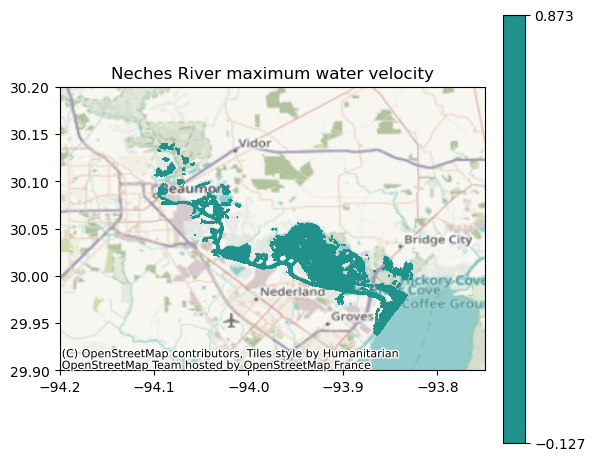

In [ ]:
def plot_check1():
    dg_nc_output_path = "/Users/liting/Documents/GitHub/Kalpana/examples/test/12-day/fort.63.dg.nc"
    nc2 = netcdf.Dataset(dg_nc_output_path, 'r')
    value_to_plot = np.array(nc2['zeta'][10])
    array_zeta_max_1 = np.ma.masked_equal(value_to_plot, -99999.0)
    min_plot_value = np.min(array_zeta_max_1)
    max_plot_value = np.max(value_to_plot)
    fig, ax = plt.subplots(figsize = (6, 6))
    ax.set_xlim([-94.2, -93.75])
    ax.set_ylim([29.9, 30.20])
    tri = mpl.tri.Triangulation(nc2['x'][:].data, nc2['y'][:].data, nc2['element'][:,:] - 1) #form the triangles
    contours = ax.tricontourf(tri, value_to_plot, levels = np.arange(min_plot_value-0.25, max_plot_value+0.25, 1), cmap = 'viridis',cbar = True)
    # levels = (minimum, maximum, bin_size)
    # I don't know why they -0.25 and +0.25 in the level. I just keep it. This is only for the plotting, and does not vary the actual zeta_max value.

    ax.set_title('Neches River maximum water velocity')

    fig.colorbar(contours, extend = 'both', ax = ax, fraction=0.046, pad=0.04, ticks=np.arange(min_plot_value-0.25, max_plot_value+0.25, 1))
    cx.add_basemap(ax, crs='epsg:4326',zoom=10)
    nc2.close()

plot_check1()

### 1. Generate .nc file for DG output, using .nc file from CG output

In [ ]:
cg_nc_path = "/Users/liting/Documents/GitHub/Kalpana/examples/test/fort.64.nc"
dg_path = "/Users/liting/Documents/GitHub/Kalpana/examples/test/12-day/fort.64"
dg_nc_output_path = "/Users/liting/Documents/GitHub/Kalpana/examples/test/12-day/fort.64.dg.nc"
time_dim = 354
## output directory: the top level directory where the shapefile will be saved


In [ ]:


# Step 1: Load x and y from CG NetCDF
with nc.Dataset(cg_nc_path, 'r') as src:
    x_vals = src.variables['x'][:]
    y_vals = src.variables['y'][:]
    node_dim = len(x_vals)

    # Step 2: Prepare storage for DG u and v
    u_data = np.zeros((time_dim, node_dim))
    v_data = np.zeros((time_dim, node_dim))

    # Step 3: Read DG fort.64
    with open(dg_path, 'r') as f:
        lines = f.readlines()

    data_lines = lines[2:]  # Skip header
    assert len(data_lines) == time_dim * (node_dim + 1), "Unexpected number of data lines in fort.64"

    for t in range(time_dim):
        for n in range(node_dim):
            line_index = t * (node_dim + 1) + n + 1
            line = data_lines[line_index].strip()
            parts = line.split()
            node_id = int(parts[0]) - 1  # Convert 1-based to 0-based
            u_val = float(parts[1])
            v_val = float(parts[2])
            u_data[t, node_id] = u_val
            v_data[t, node_id] = v_val

    # Step 4: Write new NetCDF
    with nc.Dataset(dg_nc_output_path, 'w') as dst:
        # Copy dimensions
        for dim_name, dim in src.dimensions.items():
            if dim_name == "time":
                dst.createDimension("time", time_dim)
            else:
                dst.createDimension(dim_name, len(dim))

        # Copy global attributes
        dst.setncatts({attr: src.getncattr(attr) for attr in src.ncattrs()})

        # Create and assign coordinate variables
        dst.createVariable('x', 'f8', ('node',))[:] = x_vals
        dst.createVariable('y', 'f8', ('node',))[:] = y_vals
        dst.createVariable('time', 'f8', ('time',))[:] = np.arange(time_dim)

        # Create and assign u-vel, v-vel
        u_var = dst.createVariable('u-vel', 'f8', ('time', 'node'))
        v_var = dst.createVariable('v-vel', 'f8', ('time', 'node'))
        u_var[:, :] = u_data
        v_var[:, :] = v_data

        # Add optional metadata
        u_var.units = "m/s"
        u_var.long_name = "depth-averaged eastward water velocity"
        v_var.units = "m/s"
        v_var.long_name = "depth-averaged northward water velocity"

        # Mesh-related variables to copy
        mesh_vars_to_copy = [
            "element", "adcirc_mesh", "neta", "nvdll", "max_nvdll", "ibtypee",
            "nbdv", "nvel", "nvell", "max_nvell", "ibtype", "nbvv", "depth"
        ]

        for var_name in mesh_vars_to_copy:
            if var_name in src.variables:
                var_in = src.variables[var_name]
                var_out = dst.createVariable(var_name, var_in.datatype, var_in.dimensions)
                var_out.setncatts({attr: var_in.getncattr(attr) for attr in var_in.ncattrs()})
                var_out[:] = var_in[:]



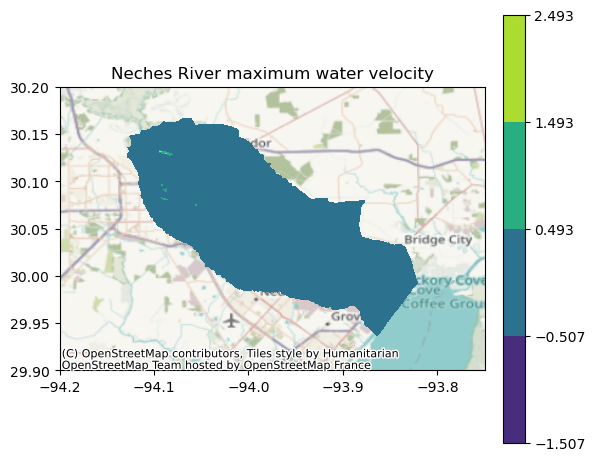

In [ ]:
def plot_check2():
    dg_nc_output_path = "/Users/liting/Documents/GitHub/Kalpana/examples/test/12-day/fort.64.dg.nc"    
    nc3 = netcdf.Dataset(dg_nc_output_path, 'r')
    value_to_plot = np.array(nc3['u-vel'][60])
    array_zeta_max_1 = np.ma.masked_equal(value_to_plot, -99999.0)
    min_plot_value = np.min(array_zeta_max_1)
    max_plot_value = np.max(value_to_plot)

    fig, ax = plt.subplots(figsize = (6, 6))
    ax.set_xlim([-94.2, -93.75])
    ax.set_ylim([29.9, 30.20])
    tri = mpl.tri.Triangulation(nc3['x'][:].data, nc3['y'][:].data, nc3['element'][:,:] - 1) #form the triangles
    contours = ax.tricontourf(tri, value_to_plot, levels = np.arange(min_plot_value-0.25, max_plot_value+0.25, 1), cmap = 'viridis',cbar = True)
    # levels = (minimum, maximum, bin_size)
    # I don't know why they -0.25 and +0.25 in the level. I just keep it. This is only for the plotting, and does not vary the actual zeta_max value.

    ax.set_title('Neches River maximum water velocity')

    fig.colorbar(contours, extend = 'both', ax = ax, fraction=0.046, pad=0.04, ticks=np.arange(min_plot_value-0.25, max_plot_value+0.25, 1))
    cx.add_basemap(ax, crs='epsg:4326',zoom=10)
    nc3.close()
plot_check2()

### 2. create masked velocity field (so the dry region has value -99999)

In [2]:
import netCDF4 as nc
import numpy as np

# === Paths ===
zeta_path = "/Users/liting/Documents/GitHub/Kalpana/examples/test/12-day/fort.63.dg.nc"
uv_path = "/Users/liting/Documents/GitHub/Kalpana/examples/test/12-day/fort.64.dg.nc"
output_path ="/Users/liting/Documents/GitHub/Kalpana/examples/test/12-day/fort.64.dg.mask.nc"

# === Constants ===
FILL_VALUE = -99999.0

# === Open source files ===
with nc.Dataset(zeta_path, 'r') as zeta_src, nc.Dataset(uv_path, 'r') as uv_src:
    zeta = zeta_src.variables['zeta'][:]
    u = uv_src.variables['u-vel'][:]
    v = uv_src.variables['v-vel'][:]

    assert zeta.shape == u.shape == v.shape, "Shape mismatch between zeta and velocity fields"

    # === Apply mask ===
    mask = (zeta == FILL_VALUE)
    u_masked = np.where(mask, FILL_VALUE, u)
    v_masked = np.where(mask, FILL_VALUE, v)

    # === Create output NetCDF ===
    with nc.Dataset(output_path, 'w', format="NETCDF3_CLASSIC") as dst:
        # Copy dimensions
        for name, dim in uv_src.dimensions.items():
            dst.createDimension(name, len(dim) if not dim.isunlimited() else None)

        # Copy global attributes
        dst.setncatts({attr: uv_src.getncattr(attr) for attr in uv_src.ncattrs()})

        # Copy coordinate variables (e.g. time, x, y)
        for name in ['time', 'x', 'y']:
            var = uv_src.variables[name]
            out_var = dst.createVariable(name, var.datatype, var.dimensions)
            out_var.setncatts({attr: var.getncattr(attr) for attr in var.ncattrs()})
            out_var[:] = var[:]

        # Copy mesh variables (optional: modify if needed)
        mesh_vars_to_copy = [
            "element", "adcirc_mesh", "neta", "nvdll", "max_nvdll", "ibtypee",
            "nbdv", "nvel", "nvell", "max_nvell", "ibtype", "nbvv", "depth"
        ]
        for var_name in mesh_vars_to_copy:
            if var_name in uv_src.variables:
                var_in = uv_src.variables[var_name]
                var_out = dst.createVariable(var_name, var_in.datatype, var_in.dimensions)
                var_out.setncatts({attr: var_in.getncattr(attr) for attr in var_in.ncattrs()})
                var_out[:] = var_in[:]

        # Create u-vel and v-vel with FILL_VALUE
        u_var = dst.createVariable('u-vel', 'f8', ('time', 'node'), fill_value=FILL_VALUE)
        v_var = dst.createVariable('v-vel', 'f8', ('time', 'node'), fill_value=FILL_VALUE)

        u_var.units = "m/s"
        u_var.long_name = "masked eastward water velocity"

        v_var.units = "m/s"
        v_var.long_name = "masked northward water velocity"

        # Assign masked data
        u_var[:, :] = u_masked
        v_var[:, :] = v_masked

print(f"✅ Masked velocity file saved to: {output_path}")


✅ Masked velocity file saved to: /Users/liting/Documents/GitHub/Kalpana/examples/test/12-day/fort.64.dg.mask.nc


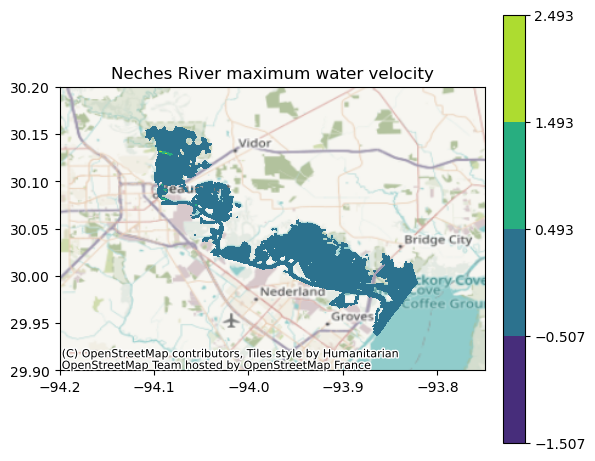

In [3]:
def plot_check3():
    dg_nc_output_path = "/Users/liting/Documents/GitHub/Kalpana/examples/test/12-day/fort.64.dg.mask.nc"    
    nc3 = netcdf.Dataset(dg_nc_output_path, 'r')
    value_to_plot = np.array(nc3['u-vel'][60])
    array_zeta_max_1 = np.ma.masked_equal(value_to_plot, -99999.0)
    min_plot_value = np.min(array_zeta_max_1)
    max_plot_value = np.max(value_to_plot)

    fig, ax = plt.subplots(figsize = (6, 6))
    ax.set_xlim([-94.2, -93.75])
    ax.set_ylim([29.9, 30.20])
    tri = mpl.tri.Triangulation(nc3['x'][:].data, nc3['y'][:].data, nc3['element'][:,:] - 1) #form the triangles
    contours = ax.tricontourf(tri, value_to_plot, levels = np.arange(min_plot_value-0.25, max_plot_value+0.25, 1), cmap = 'viridis',cbar = True)
    # levels = (minimum, maximum, bin_size)
    # I don't know why they -0.25 and +0.25 in the level. I just keep it. This is only for the plotting, and does not vary the actual zeta_max value.

    ax.set_title('Neches River maximum water velocity')

    fig.colorbar(contours, extend = 'both', ax = ax, fraction=0.046, pad=0.04, ticks=np.arange(min_plot_value-0.25, max_plot_value+0.25, 1))
    cx.add_basemap(ax, crs='epsg:4326',zoom=10)
    nc3.close()
plot_check3()

### 3. Open the .nc velocity, generate shapefiles using Kalpana for u and v and then convert them into .nc file

In [4]:
## path of the stag water output file, must be a netcdf file
ncFile ="/Users/liting/Documents/GitHub/Kalpana/examples/test/12-day/fort.64.dg.mask.nc"



## name of the variable to downscale
var1 = 'u-vel'
var2 = 'v-vel'

## Contour levels. Min, Max and Step. Max IS included as in np.arange method. Values must be in vUnitOut vertical unit.
## from 0 to 3 meters (included) every 0.5
levels = [-3.0, 3.0, 0.5] #since values outside this range are not interesting, we will only plot the range of interest

## 'polyline' or 'polygon'
## we are creating polygons in this example
conType = 'polygon'



## coordinate system of the output shapefile
epsgOut = 4326  # output in latitude and longitude, based on downscaling DEM

## input and output vertical units. For the momment only supported 'm' and 'ft'  
vUnitIn = 'm' ## Default 'm'
vUnitOut = 'm' ## Default 'ft'

## coordinate system of the adcirc input.
## Default is 4326 since ADCIRC uses latitude and longitude
epsgIn = 4326  

## complete path of the subdomain polygon kml or shapelfile, or list with the
## upper-left x, upper-left y, lower-right x and lower-right y coordinates. 
## the crs must be the same of the adcirc input file. 
subDomain = None  ## Default None

## True for export the mesh geodataframe and also save it as a shapefile. 
## for this example we are only exporting the contours, not the mesh.
exportMesh = False  ## Default False

## file name of the output mesh shapefile. Default None
meshName = None  ## Default None

## full path of the pickle file with the vertical difference between datums for each mesh node. 
dzFile = None  ## Default None

## threshold for using nearest neighbor interpolation to change datum. Points below this value won't be changed.
zeroDif = -20  ## Default -20

In [9]:
time_index = 0
#Every 20 time steps, we will create a new shapefile
while time_index < time_dim:
    # output directory
    this_stag_output_dir = stag_output_dir+'/time_index_'+str(time_index)+'/'
    if not os.path.exists(this_stag_output_dir):
        os.makedirs(this_stag_output_dir)
    
    ## complete path of the output file (*.shp or *.gpkg)
    pathOut1 = this_stag_output_dir+'neches_uvel.shp'
    pathOut2 = this_stag_output_dir+'neches_vvel.shp'
    
    
    stagnated.nc2shp63(ncFile, var1, levels, conType, pathOut1, epsgOut, vUnitOut=vUnitOut, vUnitIn=vUnitIn, epsgIn=epsgIn,
               subDomain=subDomain, exportMesh=exportMesh, meshName=meshName, dzFile=dzFile, zeroDif=zeroDif,time_index=time_index)
    stagnated.nc2shp63(ncFile, var2, levels, conType, pathOut2, epsgOut, vUnitOut=vUnitOut, vUnitIn=vUnitIn, epsgIn=epsgIn,
               subDomain=subDomain, exportMesh=exportMesh, meshName=meshName, dzFile=dzFile, zeroDif=zeroDif,time_index=time_index)
    time_index = time_index+20

Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:00<00:00, 140.50it/s]


    Ready with the contours extraction: 0.022 min
    Saving file: 0.001 min
Ready with exporting code after: 0.023 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 148.87it/s]


    Ready with the contours extraction: 0.004 min
    Saving file: 0.001 min
Ready with exporting code after: 0.006 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:00<00:00, 42.53it/s]


    Ready with the contours extraction: 0.013 min
    Saving file: 0.002 min
Ready with exporting code after: 0.015 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 39.82it/s]


    Ready with the contours extraction: 0.013 min
    Saving file: 0.002 min
Ready with exporting code after: 0.015 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:00<00:00, 56.61it/s] 


    Ready with the contours extraction: 0.010 min
    Saving file: 0.002 min
Ready with exporting code after: 0.012 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 53.24it/s] 


    Ready with the contours extraction: 0.010 min
    Saving file: 0.002 min
Ready with exporting code after: 0.011 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:00<00:00, 69.70it/s] 


    Ready with the contours extraction: 0.008 min
    Saving file: 0.002 min
Ready with exporting code after: 0.011 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 64.84it/s] 


    Ready with the contours extraction: 0.008 min
    Saving file: 0.002 min
Ready with exporting code after: 0.010 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:00<00:00, 43.06it/s] 


    Ready with the contours extraction: 0.012 min
    Saving file: 0.002 min
Ready with exporting code after: 0.015 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 36.21it/s]


    Ready with the contours extraction: 0.014 min
    Saving file: 0.002 min
Ready with exporting code after: 0.016 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:00<00:00, 68.67it/s] 


    Ready with the contours extraction: 0.008 min
    Saving file: 0.002 min
Ready with exporting code after: 0.010 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 58.24it/s] 


    Ready with the contours extraction: 0.009 min
    Saving file: 0.002 min
Ready with exporting code after: 0.011 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:00<00:00, 62.33it/s] 


    Ready with the contours extraction: 0.009 min
    Saving file: 0.002 min
Ready with exporting code after: 0.011 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 57.79it/s]


    Ready with the contours extraction: 0.009 min
    Saving file: 0.002 min
Ready with exporting code after: 0.011 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:00<00:00, 59.84it/s] 


    Ready with the contours extraction: 0.009 min
    Saving file: 0.002 min
Ready with exporting code after: 0.011 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 47.38it/s]


    Ready with the contours extraction: 0.011 min
    Saving file: 0.002 min
Ready with exporting code after: 0.013 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:00<00:00, 52.94it/s] 


    Ready with the contours extraction: 0.010 min
    Saving file: 0.002 min
Ready with exporting code after: 0.013 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 62.18it/s]


    Ready with the contours extraction: 0.008 min
    Saving file: 0.002 min
Ready with exporting code after: 0.010 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:00<00:00, 39.17it/s] 


    Ready with the contours extraction: 0.014 min
    Saving file: 0.002 min
Ready with exporting code after: 0.015 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 49.30it/s]


    Ready with the contours extraction: 0.010 min
    Saving file: 0.002 min
Ready with exporting code after: 0.012 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:00<00:00, 45.42it/s] 


    Ready with the contours extraction: 0.012 min
    Saving file: 0.002 min
Ready with exporting code after: 0.014 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 53.39it/s]


    Ready with the contours extraction: 0.010 min
    Saving file: 0.002 min
Ready with exporting code after: 0.011 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:00<00:00, 46.51it/s] 


    Ready with the contours extraction: 0.012 min
    Saving file: 0.002 min
Ready with exporting code after: 0.013 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 53.44it/s]


    Ready with the contours extraction: 0.010 min
    Saving file: 0.002 min
Ready with exporting code after: 0.011 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:00<00:00, 40.19it/s] 


    Ready with the contours extraction: 0.013 min
    Saving file: 0.002 min
Ready with exporting code after: 0.015 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 38.10it/s]


    Ready with the contours extraction: 0.013 min
    Saving file: 0.002 min
Ready with exporting code after: 0.015 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:00<00:00, 30.69it/s] 


    Ready with the contours extraction: 0.017 min
    Saving file: 0.002 min
Ready with exporting code after: 0.019 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 33.77it/s]


    Ready with the contours extraction: 0.015 min
    Saving file: 0.002 min
Ready with exporting code after: 0.017 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:00<00:00, 33.47it/s] 


    Ready with the contours extraction: 0.016 min
    Saving file: 0.002 min
Ready with exporting code after: 0.019 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 37.71it/s]


    Ready with the contours extraction: 0.013 min
    Saving file: 0.002 min
Ready with exporting code after: 0.015 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:00<00:00, 33.95it/s] 


    Ready with the contours extraction: 0.016 min
    Saving file: 0.002 min
Ready with exporting code after: 0.018 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 36.14it/s]


    Ready with the contours extraction: 0.014 min
    Saving file: 0.002 min
Ready with exporting code after: 0.016 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:00<00:00, 35.29it/s] 


    Ready with the contours extraction: 0.015 min
    Saving file: 0.002 min
Ready with exporting code after: 0.017 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 34.06it/s]


    Ready with the contours extraction: 0.014 min
    Saving file: 0.002 min
Ready with exporting code after: 0.017 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 29/29 [00:01<00:00, 25.44it/s] 


    Ready with the contours extraction: 0.020 min
    Saving file: 0.003 min
Ready with exporting code after: 0.023 min
Start exporting adcirc to shape


Compute contours using Dask: 100%|██████████| 27/27 [00:00<00:00, 27.77it/s]

    Ready with the contours extraction: 0.017 min
    Saving file: 0.003 min
Ready with exporting code after: 0.020 min


In [10]:
time_index = 0
#Every 20 time steps, we will create a new shapefile
while time_index < time_dim:
    this_stag_output_dir = stag_output_dir+'/time_index_'+str(time_index)+'/'

    pathOut1 = this_stag_output_dir+'neches_uvel.shp'
    pathOut2 = this_stag_output_dir+'neches_vvel.shp'

    stagnated.shapefile_to_netcdf(pathOut1, pathOut2,this_stag_output_dir+'neches_stag.nc', nx=1000, ny=1000)

    time_index = time_index+20

lon_min1: -94.09638506142504, lon_max1: -93.82583696619967, lat_min1: 29.936486, lat_max1: 30.13400106847754
NetCDF file '/Users/liting/Desktop/stag-water2/time_index_0/neches_stag.nc' created successfully.
lon_min1: -94.09943109035154, lon_max1: -93.82583696619967, lat_min1: 29.936486, lat_max1: 30.150582126289503
NetCDF file '/Users/liting/Desktop/stag-water2/time_index_20/neches_stag.nc' created successfully.
lon_min1: -94.09943109036409, lon_max1: -93.82289199142518, lat_min1: 29.936486, lat_max1: 30.158588140178328
NetCDF file '/Users/liting/Desktop/stag-water2/time_index_40/neches_stag.nc' created successfully.
lon_min1: -94.10919011233749, lon_max1: -93.82092700000001, lat_min1: 29.936486, lat_max1: 30.158588141116415
NetCDF file '/Users/liting/Desktop/stag-water2/time_index_60/neches_stag.nc' created successfully.
lon_min1: -94.125979, lon_max1: -93.82092700000001, lat_min1: 29.936486, lat_max1: 30.163437105463554
NetCDF file '/Users/liting/Desktop/stag-water2/time_index_80/nec

### 3. Check if things are good

In [11]:
nc_path_4 = stag_output_dir+'/time_index_0/neches_stag.nc' 
nc4 = netcdf.Dataset(nc_path_4, 'r')
#check if this netcdf file looks right
print(nc4)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Converted Shapefile to NetCDF
    history: Created with Python script using geopandas, rasterio, and netCDF4
    dimensions(sizes): lon(1000), lat(1000)
    variables(dimensions): float32 lon(lon), float32 lat(lat), float32 stag_water(lat, lon)
    groups: 


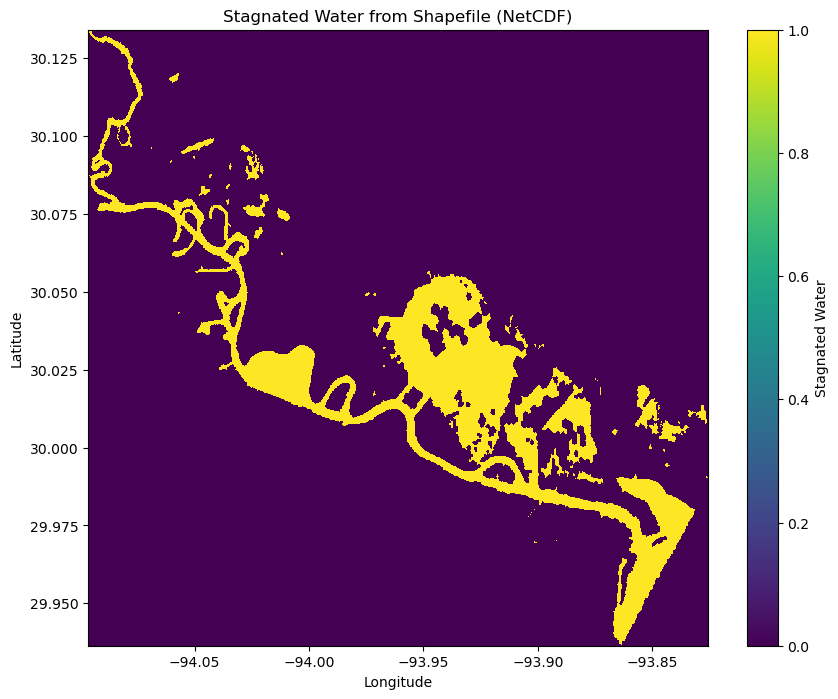

In [12]:

ds = netcdf.Dataset(stag_output_dir+"/time_index_0/neches_stag.nc", 'r')


# Step 2: Read the variables (lon, lat, and stag_water)
lon = ds.variables['lon'][:]
lat = ds.variables['lat'][:]
stag_water = ds.variables['stag_water'][:]

# Step 3: Create a meshgrid of lon and lat for plotting
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Step 4: Plot using matplotlib
plt.figure(figsize=(10, 8))
plt.pcolormesh(lon_grid, lat_grid, stag_water, shading='auto', cmap='viridis')  # Plot the stag_water variable

# Add a colorbar to show the color intensity corresponding to stag_water values
plt.colorbar(label='Stagnated Water')

# Label axes
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Stagnated Water from Shapefile (NetCDF)')

# Display the plot
plt.show()

# Step 5: Close the NetCDF file
ds.close()
